**Create 31-day running mean climatology for ERA-5 v1.1 tas, tmax, tmin**

In [83]:
%matplotlib inline

import xarray as xr
import numpy as np
import os as os
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
import itertools
import datetime 
import toolz
from datetime import date
from pathlib import Path, PurePath
from xclim.core.calendar import convert_calendar

import sys

import dask.distributed as dd
import dask
import rhg_compute_tools.kubernetes as rhgk

In [84]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(100)

In [85]:
client

Client Scheduler: gateway://traefik-impactlab-hub-dask-gateway.impactlab-hub:80/impactlab-hub.f0315012d6bc4cd1ae9e38568e37a4cb Dashboard: /services/dask-gateway/clusters/impactlab-hub.f0315012d6bc4cd1ae9e38568e37a4cb/status,Cluster Workers: 4 Cores: 4 Memory: 96.64 GB


In [110]:
cluster.close()

In [95]:
yrs = np.arange(1994,2016) 

In [96]:
def pull_ERA5_variable(variable):
    filenames = []
    
    for num_yrs in range(len(yrs)):
        filename = '/gcs/impactlab-data/climate/source_data/ERA-5/day/{}/v1.1/{}_daily_{}-{}.nc'.format(variable, variable, yrs[num_yrs], yrs[num_yrs])
        filenames.append(filename)
    
    era5_var = xr.open_mfdataset(filenames, 
                               concat_dim='time', combine='by_coords')
    
    var_all = era5_var[variable]
    
    return var_all


In [97]:
da = pull_ERA5_variable('tmin')

In [98]:
da = da.persist()

In [99]:
# remove leap days and convert calendar to no-leap
da = convert_calendar(da, 'noleap')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [100]:
def assign_coords(da):
    years = np.arange(da.time.dt.year.min(),da.time.dt.year.max()+1)
    
    da_wcoords = da.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(years)).flatten(),
                                                dims=('time'),
                                                coords={'time':da.time})).persist()
    return da_wcoords

In [101]:
da = assign_coords(da)

In [102]:
da_dayofyear_mean = da.sel(time=slice('1994-12-17','2015-01-15')).groupby('dayofyear').mean().persist()

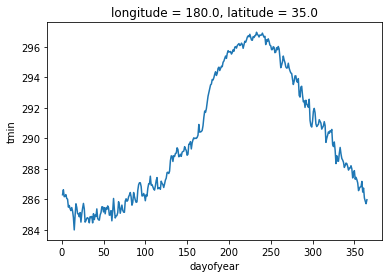

In [103]:
da_dayofyear_mean.sel(latitude=35.0,longitude=180.0).plot()

In [104]:
da_dayofyear_mean.nbytes / (1024**3)

1.4117270708084106

In [105]:
da_dayofyear_mean = da_dayofyear_mean.load()

In [106]:
def rolling_31day_mean(da):
    roll = da.pad(dayofyear=15, mode='wrap').rolling(dayofyear=31, center=True).mean().dropna('dayofyear')
    return roll

In [107]:
da_rolling_mean = rolling_31day_mean(da_dayofyear_mean)

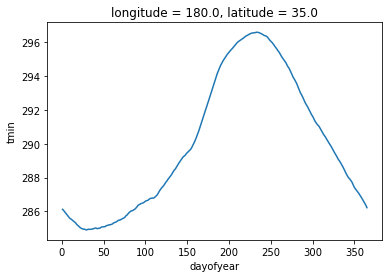

In [108]:
da_rolling_mean.sel(latitude=35.0,longitude=180.0).plot()

In [109]:
def create_netcdf(da):
    '''
    create netcdf file.
    '''
    out_direc = ('/gcs/impactlab-data/climate/source_data/ERA-5/climatology/v1.1/')
    out_filename = ('tmin_1995_2015_climo.nc')
    
    if not Path(out_direc).exists():
                    Path(out_direc).mkdir(parents=True, exist_ok=True)
            
    # add attributes to dataset and save file 
    attrsdt = {
        'author': 'Meredith Fish',
        'contact': 'meredith.fish@rutgers.edu',
        'project': ('downscaling CMIP6'),
        'source': ('/gcs/climate/source_data/ERA-5/day/tmin/v1.1'),
        'method': ('31-rolling mean climatology, no leap days'),
        'created': str(date.today()),
        'units': 'K'}

    da.attrs.update(attrsdt)
    
    # save file
    da.to_netcdf(Path(PurePath(out_direc).joinpath(out_filename)))

In [79]:
create_netcdf(da_rolling_mean)